# Workflow

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from astropy.coordinates import EarthLocation, AltAz, SkyCoord
from astropy.time import Time, TimeDelta
import astropy.units as u
from utils import Leg_poly_proj, view_samples
from flicker_model import sim_noise, flicker_cov

## Scan

Coordinates:
- MeerKAT Telescope Location:
	-	Latitude: -30.7130° S
	-	Longitude: 21.4430° E

- Antenna pointing directions:
	-	Azimuth
	-	Elevation

- Diffuse sky coordinates:
	-	RA 
	-	DEC

- healpy expects (theta, phi) in spherical coordinates:
	-	theta = pi/2 - DEC
	-	phi = RA

Total length of TOD:  2860


Text(0, 0.5, 'Elevation (deg)')

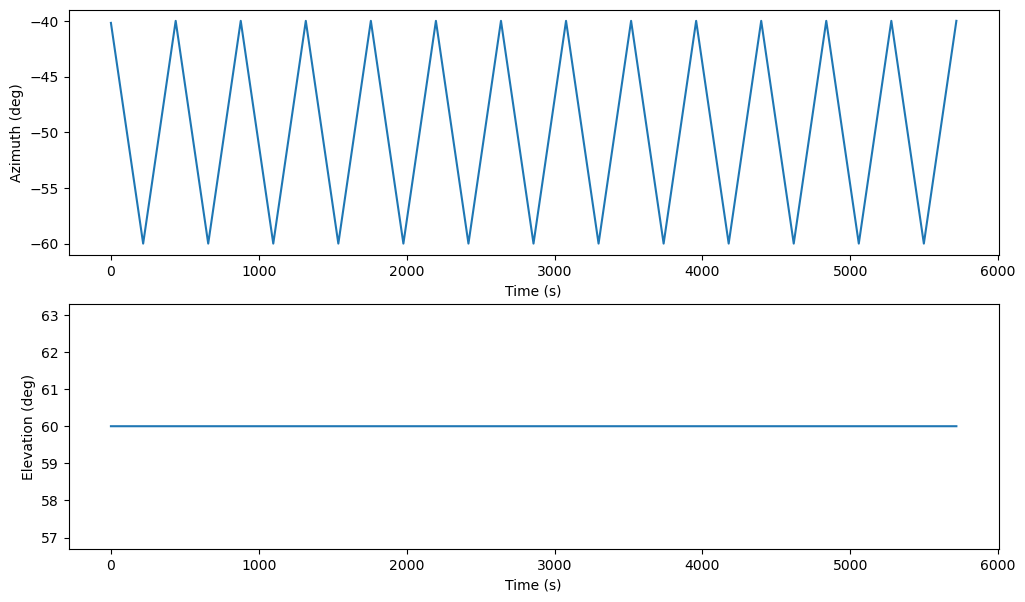

In [2]:
# Antenna position: Latitude: -30.7130° S; Longitude: 21.4430° E.

# ---- Define telescope location ----
telescope_lat = -30.7130  # MeerKAT latitude in degrees
telescope_lon = 21.4430   # MeerKAT longitude in degrees
telescope_height = 1054    # MeerKAT altitude in meters

location = EarthLocation(lat=telescope_lat * u.deg, lon=telescope_lon * u.deg, height=telescope_height * u.m)


# ---- Define observation parameters ----

# Antenna pointings: Azimuth list and Elevation, in degrees
aux = np.linspace(-60, -40, 111)
# aux = np.linspace(-65, -35, 171)
azimuths = np.concatenate((aux[1:-1][::-1], aux))
#azimuths = np.concatenate((aux, aux[1:-1][::-1]))

# Generate 13 repeats of the azimuths
azimuths = np.tile(azimuths, 13)


elevation = 41.7    # Elevation in degrees

elevation = 60    # Elevation in degrees

# Total length of TOD
ntime = len(azimuths)
print("Total length of TOD: ", ntime)
dtime = 2.0

t_list = np.arange(ntime) * dtime 


plt.figure(figsize=(12, 7))
# Generate the equatorial coordinates of the pointings:
ra_list = []
dec_list = []

plt.subplot(211)
plt.plot(t_list, azimuths)
plt.xlabel('Time (s)')
plt.ylabel('Azimuth (deg)')

plt.subplot(212)
plt.plot(t_list, elevation*np.ones_like(azimuths))
plt.xlabel('Time (s)')
plt.ylabel('Elevation (deg)')


In [3]:
# ---- Define start and end times in SAST ----
start_time_sast = "2024-02-23 19:54:07.397"
#end_time_sast = "2024-02-23 22:12:04.632"

# ---- Convert to UTC (SAST = UTC+2) ----
start_time = Time(start_time_sast) - TimeDelta(2 * u.hour)
#end_time = Time(end_time_sast) - TimeDelta(2 * u.hour)

# ---- Generate time list using numpy.arange ----
dt = 2  # Time step in seconds
time_list = start_time + TimeDelta(t_list, format='sec')

# ---- Print results ----
print(f"Generated {len(time_list)} timestamps.")

Generated 2860 timestamps.


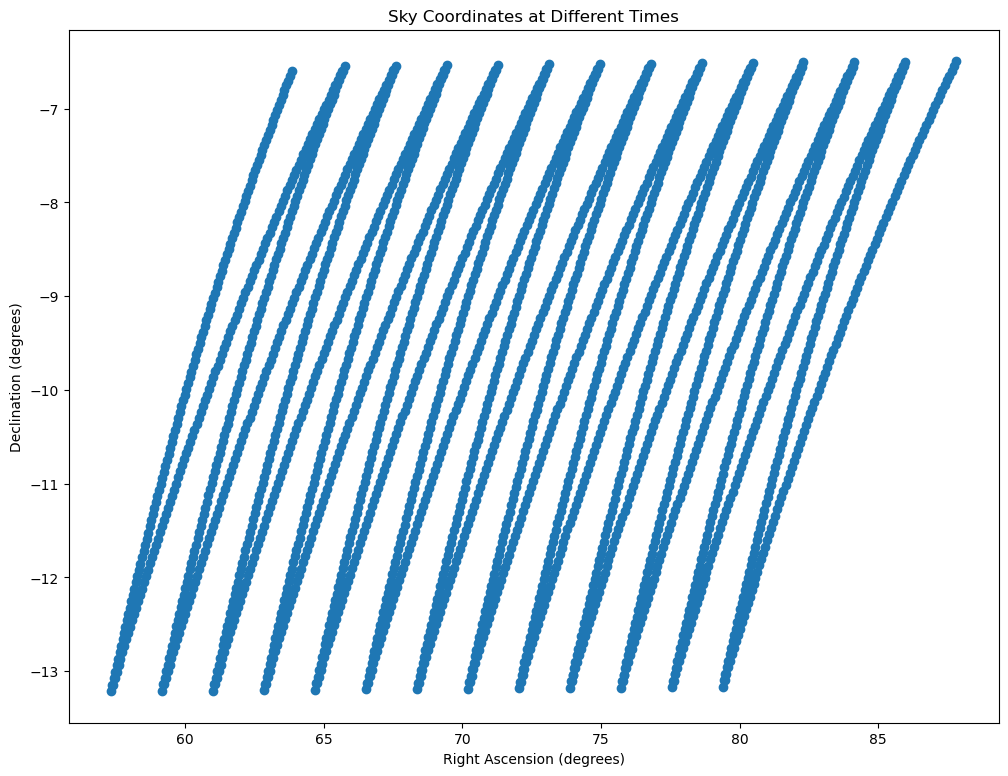

In [4]:
# ---- Create AltAz coordinate frame ----
altaz_frame = AltAz(obstime=time_list, location=location)

# ---- Convert Az/El to Equatorial (RA, Dec) ----
equatorial_coords = SkyCoord(az=azimuths*u.deg, alt=elevation*u.deg, frame=altaz_frame).transform_to("icrs")


# Convert the equatorial coordinates to pixel indices
# Note: healpy expects (theta, phi) in spherical coordinates
theta_c = np.pi/2 - equatorial_coords.dec.radian  # Convert Dec to theta
phi_c = equatorial_coords.ra.radian               # RA is already phi

# ---- Plot results ----
# Generate a 2D plot of (RA, Dec) coordinates
plt.figure(figsize=(12, 9))
plt.scatter(equatorial_coords.ra, equatorial_coords.dec)
plt.xlabel("Right Ascension (degrees)")
plt.ylabel("Declination (degrees)")
plt.title("Sky Coordinates at Different Times")
plt.show()


### Beam setup

 Gaussian Beam (FWHM = 1.1 degrees)

$
\text{FWHM} = 2 \sigma \sqrt{2 \ln(2)}
$

In [5]:
# Define beam parameters
FWHM = 1.1  # Full Width at Half Maximum in degrees
sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))  # Convert FWHM to sigma (degrees)
sigma_rad = np.radians(sigma)  # Convert to radians

In [6]:
def pixel_angular_size(nside):
    """Compute the angular size (in degrees and arcminutes) of a HEALPix pixel."""
    npix = hp.nside2npix(nside)  # Total number of pixels
    omega_pix = 4 * np.pi / npix  # Pixel area in steradians
    theta_pix_deg = np.sqrt(omega_pix) * (180 / np.pi)  # Approximate pixel width in degrees
    theta_pix_arcmin = theta_pix_deg * 60  # Convert to arcminutes
    return theta_pix_deg, theta_pix_arcmin

# Example usage
nside = 64 # Change NSIDE as needed
theta_deg, theta_arcmin = pixel_angular_size(nside)
print(f"NSIDE = {nside}")
print(f"Pixel angular size: {theta_deg:.6f} degrees ({theta_arcmin:.2f} arcminutes)")

NSIDE = 64
Pixel angular size: 0.916130 degrees (54.97 arcminutes)


Number of covered pixels: 253


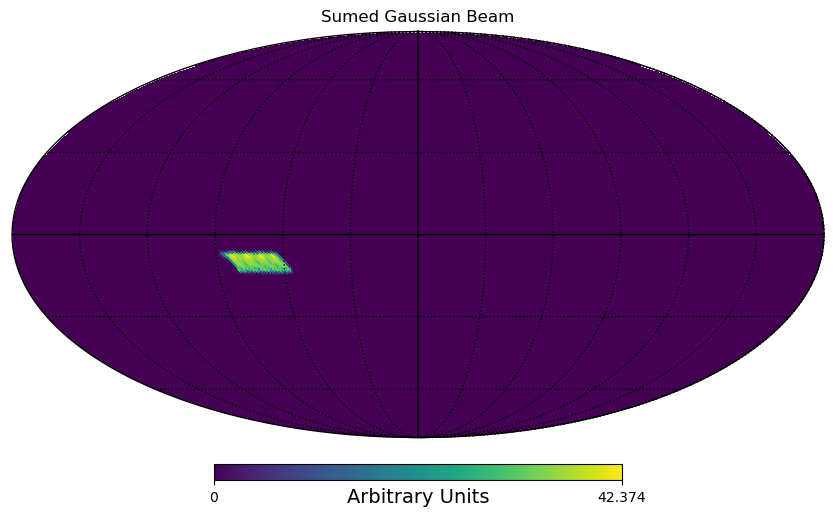

In [7]:
# Define HEALPix resolution
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)  

# Get HEALPix pixel coordinates (theta, phi)
theta, phi = hp.pix2ang(NSIDE, np.arange(NPIX))

# Generate a initial boolean map with all pixels zero
bool_map = np.zeros(NPIX, dtype=bool)
sum_map = np.zeros(NPIX, dtype=float)
# ---- Set the threshold ----
threshold = 1e-1  # Example: Get all pixels where the value is > 0.

for ti in range(ntime):
    # Compute angular separation between each pixel and the beam center
    cos_sep = np.cos(theta) * np.cos(theta_c[ti]) + np.sin(theta) * np.sin(theta_c[ti]) * np.cos(phi - phi_c[ti])
    cos_sep = np.clip(cos_sep, -1, 1)  # Ensure within valid range
    angular_sep = np.arccos(cos_sep)  # Separation in radians
    # Compute Gaussian beam response centered at (RA_center, Dec_center)
    beam_map = np.exp(-0.5 * (angular_sep / sigma_rad) ** 2)
    # Normalize the beam (optional, ensures peak = 1)
    beam_map /= np.max(beam_map)
    sum_map += beam_map
    # Get the "or" map of the bool_map and beam_map
    bool_map = np.logical_or(bool_map, beam_map > threshold)

# Count the number of "1" pixels in bool_map
num_pixels = np.sum(bool_map)
print(f"Number of covered pixels: {num_pixels}")

# Get the pixel indices of the "1" pixels:
pixel_indices = np.where(bool_map)[0]

# Save HEALPix map to file
#hp.write_map("gaussian_beam_pointing.fits", beam_map, overwrite=True)

# Plot the beam in Mollweide projection
hp.mollview(sum_map, title=f"Sumed Gaussian Beam", unit="Arbitrary Units")
hp.graticule()

In [ ]:
hp.mollview(bool_map, title=f"Boolean map: masked pixels", unit="Arbitrary Units")
hp.graticule()

In [8]:
# Get pixels of skymap where corresponding mask value (bool_map) is true 

beam_proj = np.zeros((ntime, num_pixels))

for ti in range(ntime):
    # Compute angular separation between each pixel and the beam center
    cos_sep = np.cos(theta) * np.cos(theta_c[ti]) + np.sin(theta) * np.sin(theta_c[ti]) * np.cos(phi - phi_c[ti])
    cos_sep = np.clip(cos_sep, -1, 1)  # Ensure within valid range
    angular_sep = np.arccos(cos_sep)  # Separation in radians
    # Compute Gaussian beam response centered at (RA_center, Dec_center)
    beam_map = np.exp(-0.5 * (angular_sep / sigma_rad) ** 2)
    # Normalize the beam (optional, ensures peak = 1)
    beam_map /= np.max(beam_map)
    beam_proj[ti] = beam_map[pixel_indices]

norm=np.sum(beam_proj, axis=1)
beam_proj/=norm[:,None]


### Sky temperature simulation

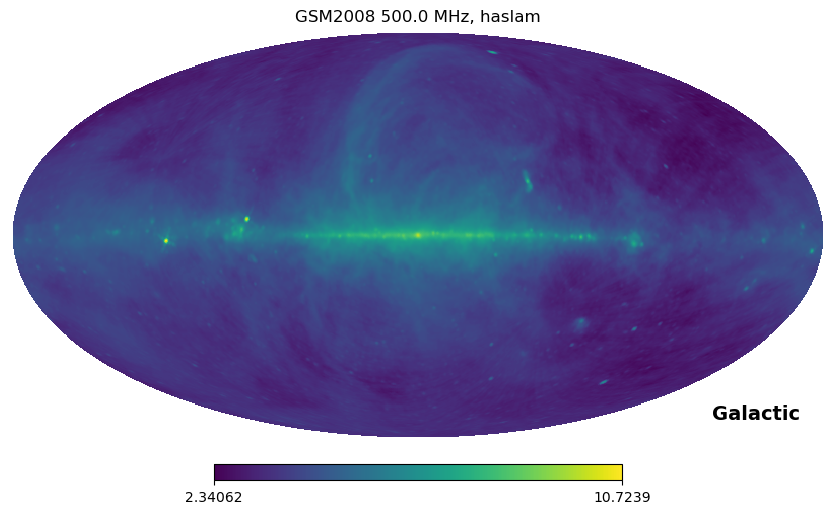

In [9]:
from pygdsm import GlobalSkyModel
gsm = GlobalSkyModel()
skymap = gsm.generate(500)
skymap = hp.ud_grade(skymap, nside_out=NSIDE)
true_Tsky = skymap[pixel_indices]
gsm.view(logged=True)



### Noise diode setup

In [10]:
# generate a vector of length ntime, every 10 elements there is a 1, the rest is 0
def generate_vector(ntime):
    vector = np.zeros(ntime)
    for i in range(0, ntime, 10):
        vector[i] = 1
    return vector

ndiode_proj = generate_vector(ntime)

T_ndiode = 10.0

### Receiver temperature

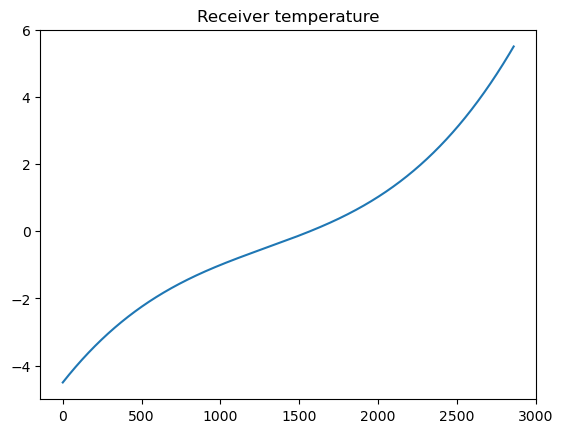

In [11]:
rec_proj = Leg_poly_proj(4, t_list)[:, 1:]
rec_params=np.array([4, 0.5, 1])
plt.title("Receiver temperature")
plt.plot(rec_proj @ rec_params)

### Gain and noise setup 

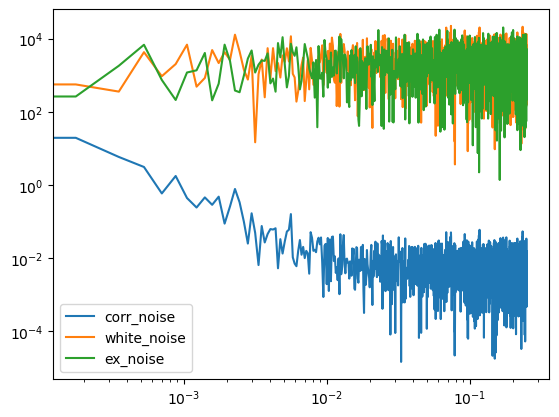

In [12]:
from numpy.linalg import cholesky

gain_proj = Leg_poly_proj(4, t_list)
gain_params=np.array([2, 0.5, 1.5, 0.5])*2
# mu0 = np.sin(2*np.pi*0.001*t_list)
mu0 = 0.
gains = gain_proj @ gain_params + mu0

f0, fc, alpha = 1e-4, 2e-5, 2.0
sigma_2 = 1/(4e5)

noise = sim_noise(f0, fc, alpha, t_list, n_samples=1, white_n_variance=sigma_2)[0]
covmat = flicker_cov(t_list, f0, fc, alpha, white_n_variance=sigma_2, only_row_0=False)
# invert the symmetric matrix, covmat
Ninv = np.linalg.inv(covmat)

aux_mat = cholesky(Ninv, upper=True)
white_noise = aux_mat @ noise

# Check if white noise is white: compare PSD of corr_noise and white_noise
psd_corr = np.abs(np.fft.rfft(noise))**2
psd_white = np.abs(np.fft.rfft(white_noise))**2
freqs = np.fft.rfftfreq(ntime, d=2)
# plot psd
plt.loglog(freqs, psd_corr, label='corr_noise')
plt.loglog(freqs, psd_white, label='white_noise')
ex_noise = np.random.randn(ntime)
psd_ex = np.abs(np.fft.rfft(ex_noise))**2
plt.loglog(freqs, psd_ex, label='ex_noise')

plt.legend()

In [15]:
inv_gains = 1/gains
p_gain_var = gain_proj.T @ (inv_gains[:, np.newaxis] * Ninv * inv_gains[np.newaxis, :]) @ gain_proj
p_gain_var = np.diag(np.linalg.inv(p_gain_var))
p_gain_var

array([0.00236494, 0.0005306 , 0.00136824, 0.00022486])

In [ ]:
plt.plot(gains)

In [16]:
from Tsys_sampler import Tsys_model

TOD_ndiode = T_ndiode*ndiode_proj
TOD_rec = rec_proj @ rec_params
Tsys_sim = Tsys_model([beam_proj, rec_proj, ndiode_proj], [true_Tsky, rec_params, T_ndiode])
TOD_sim = Tsys_sim * (1+noise) * gains 


ImportError: cannot import name 'Tsys_model' from 'Tsys_sampler' (/Users/zzhang/Workspace/flicker/Tsys_sampler.py)

Generate a sequence of time-ordered data for a scan of a receiver.

## Noise Parameter Sampler

In [17]:
from noise_sampler import noise_params_sampler, flicker_likeli_func
from mcmc_sampler import mcmc_sampler

In [ ]:
# logn_params = [np.log10(f0), np.log10(fc), alpha]
# boundaries = [[-12.,0.], [-12.,0.], [1.01,5.0]]
# log_likeli = flicker_likeli_func(t_list, TOD_sim, gains, Tsys_sim, wnoise_var=2.5e-6, boundaries=None)
# noise_samples_Jeff = mcmc_sampler(log_likeli, logn_params, p_std=0.05, 
#                     nsteps=50,  # steps for each chain
#                     n_samples=1,
#                     prior_func=None,
#                     num_Jeffrey=False,
#                     return_sampler=False)

# view_samples(noise_samples_Jeff, logn_params)


In [ ]:
# noise_samples_no_prior = noise_params_sampler(t_list, TOD_sim, gains, Tsys_sim, 
#                         sigma_2,
#                         nwalkers=6, 
#                         nsteps=100, 
#                         n_samples=300,
#                         log_scale=True, 
#                         prior_func=None,
#                         return_sampler=False)

# noise_samples = noise_samples_no_prior
# # Calculate statistics
# mean = np.mean(noise_samples, axis=0)
# std = np.std(noise_samples, axis=0)

# # Create subplots for four parameters
# fig, axes = plt.subplots(1, 3, figsize=(15, 6))
# axes = axes.ravel()

# logn_params = np.log10(f0), np.log10(fc), alpha
# params_names = ['log(f0)', 'log(fc)', 'alpha']
# for i in range(3):
#     # Plot histogram of samples for each parameter
#     axes[i].hist(noise_samples[:, i], bins=50, density=True, alpha=0.6, label='Samples')
    
#     # Plot true value line
#     axes[i].axvline(x=logn_params[i], color='r', linestyle='-', label='True Value', linewidth=2, alpha=0.7)
    
#     # Plot mean value line
#     axes[i].axvline(x=mean[i], color='g', linestyle='--', label='Mean')
    
#     # Add labels and title
#     axes[i].set_xlabel('Coefficient')
#     axes[i].set_ylabel('Density')
#     axes[i].set_title(f'Parameter {params_names[i]}')
#     axes[i].legend()
    
#     # Print numerical comparison for each parameter
#     print(f"\nGain Parameter {i+1}:")
#     print(f"True value: {logn_params[i]:.6f}")
#     print(f"Mean sampled: {mean[i]:.6f}")
#     print(f"Standard deviation: {std[i]:.6f}")

# plt.suptitle('Comparison of True Values, Mean for Noise Parameters (No Prior) (300 samples)')

# plt.tight_layout()
# plt.show()

## Gain Sampler Test

To test the gain sampler, we sample gain coefficients with given noise parameters and system parameters.

Iterative Generalised Least Squares (GLS) procedure.

In [18]:
from gain_sampler import gain_coeff_sampler

gain_samples = gain_coeff_sampler(TOD_sim, 
                    gain_proj, 
                    Tsys_sim, 
                    covmat, 
                    mu=mu0,
                    n_samples=4000,
                    tol=1e-20,
                    prior_cov_inv=None, 
                    prior_mean=None, 
                    solver=None)

view_samples(gain_samples, gain_params)


NameError: name 'TOD_sim' is not defined

In [19]:
inv_gains = 1/gains
p_gain_var = gain_proj.T @ (inv_gains[:, np.newaxis] * Ninv * inv_gains[np.newaxis, :]) @ gain_proj
p_gain_var = np.diag(np.linalg.inv(p_gain_var))
np.sqrt(p_gain_var)

array([0.04863061, 0.02303466, 0.03698967, 0.01499534])

## System temperature sampler

In [ ]:
from Tsys_sampler import Tsys_coeff_sampler, overall_operator

TOD_ndiode = T_ndiode*ndiode_proj

Tsys_proj = overall_operator([beam_proj, rec_proj])


Tsys_params = Tsys_coeff_sampler(TOD_sim, 
                       gains, 
                       Tsys_proj, 
                       covmat, 
                       n_samples=100,
                       mu=TOD_ndiode,
                       tol=1e-17,
                       prior_cov_inv=None, 
                       prior_mean=None, 
                       solver=None)


In [ ]:
Tsky_samples = Tsys_params[:,:num_pixels]
Tsky_mean = np.mean(Tsky_samples, axis=0)
Tsky_std = np.std(Tsky_samples, axis=0)
#Trec_samples = Tsys_params[:,num_pixels:]
#view_samples(Trec_samples, rec_params)

In [ ]:
# Compare true Tsky and sampled Tsky

plt.figure(figsize=(10, 6))
plt.plot(true_Tsky, label='True Tsky')
# Plot the mean of the samples, with error bars being the standard deviation
plt.errorbar(np.arange(len(true_Tsky)), Tsky_mean, yerr=Tsky_std, label='Sampled Tsky')
plt.ylim(5, 12)
plt.legend()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(true_Tsky, label='True Tsky')
# Plot the mean of the samples, with error bars being the standard deviation
plt.plot(Tsky_mean, label='Mean of samples')
plt.ylim(5, 12)
plt.legend()

In [ ]:
plt.plot(Tsky_std)

## Test the full Gibbs sampler

In [ ]:
from full_Gibbs_sampler import full_Gibbs_sampler_singledish 

In [ ]:
# read off the samples from Tsys_samples.npy
#

Tsys_samples = np.load('Tsys_samples.npy')

In [ ]:
Tsky_samples = Tsys_samples[:, :num_pixels]
Tmean = np.mean(Tsky_samples, axis=0)
Tstd = np.std(Tsky_samples, axis=0)



# plot the mean with error bars
# plt.errorbar(range(len(Tmean)), Tmean, yerr=Tstd, fmt='o', label='mean Tsky')
plt.plot(range(len(Tmean)), Tmean, label='mean Tsky')
plt.plot(range(len(Tmean)), true_Tsky, label='true Tsky', linestyle='--')
plt.ylim(5, 15)
plt.legend()



In [ ]:
# Show the healpix maps

true_map = np.zeros(NPIX, dtype=float)
sample_mean_map = np.zeros(NPIX, dtype=float)
sample_std_map = np.zeros(NPIX, dtype=float)

true_map[pixel_indices] = true_Tsky
sample_mean_map[pixel_indices] = Tmean
sample_std_map[pixel_indices] = Tstd


In [ ]:
# view the map using the saved colorbar

hp.mollview(true_map, title="True Tsky", unit="K", cmap='jet', min=5, max=15)

In [ ]:
hp.mollview(sample_mean_map, title="Mean Sampled Tsky", unit="K", cmap='jet', min=5, max=15)